# NVDA and CAKE Summary Statistics

In [68]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# trades level schema
# needs to be updated for correct trading hours
df = pd.read_csv('xnas-itch-nvidia-cake.csv', parse_dates=['ts_recv', 'ts_event'])


In [69]:
# Split up and prepare dataset

def prepare_bid_ask_data(df):
    """ Helper function to create bid_price, ask_price, bid_depth, and ask_depth columns
        that will be used for later summary statistic calculations."""
    
    # Create bid and ask price columns based on the 'side' column
    df['bid_price'] = df['price'].where(df['side'] == 'B', None)
    df['ask_price'] = df['price'].where(df['side'] == 'A', None)
        
    # Forward fill the missing bid and ask prices and depths
    df['bid_price'] = df['bid_price'].ffill()
    df['ask_price'] = df['ask_price'].ffill()
    
    return df

#nvda_df = prepare_bid_ask_data(df[df['symbol'] == 'NVDA'].copy())
#cake_df = prepare_bid_ask_data(df[df['symbol'] == 'CAKE'].copy())

nvda_df = pd.read_csv('xnas-itch-20240822.tbbo.NVDA.csv', parse_dates=['ts_recv', 'ts_event'])
cake_df = pd.read_csv('xnas-itch-20240822.tbbo.CAKE.csv', parse_dates=['ts_recv', 'ts_event'])

nvda_df_mbo = df_mbo[df_mbo['symbol'] == 'NVDA'].copy()
cake_df_mbo = df_mbo[df_mbo['symbol'] == 'CAKE'].copy()


# Helper functions - contain functionality that calculates results

In [73]:
def calculate_5s_price_impact(df):
    ''' Helper function that contains logic to calculate 5 second price impact.'''

    # Calculate the midpoint price
    df['midpoint'] = (df['bid_price'] + df['ask_price']) / 2

    # Lag midpoint by 5 seconds
    df['midpoint_lag'] = df['midpoint'].shift(5)

    # Calculate the midpoint return
    df['midpoint_return'] = df['midpoint'] - df['midpoint_lag']

    # Create a trade sign column based on the 'side' (-1 for 'Ask', +1 for 'Bid')
    df['trade_sign'] = df['side'].apply(lambda x: 1 if x == 'B' else -1)

    # Remove NaN values that result from the shift
    clean = df.dropna(subset=['midpoint_return', 'trade_sign'])

    # Perform the regression of 5-second midpoint return on trade sign
    price_impact_model = sm.OLS(pd.to_numeric(clean['midpoint_return']), clean['trade_sign']).fit()

    # Display the summary of the regression model
    return price_impact_model.summary()


def calculate_depth_at_2x_spread(df_mbo):
    
    # Filter for only relevant actions to speed up book calculations
    df_mbo_filtered = df_mbo[df_mbo['action'].isin(['A', 'C'])].copy()

    # Group data by second
    df_mbo_filtered['second'] = df_mbo_filtered['ts_event'].dt.floor('S')

    # Initialize dictionaries to store order books for bids and asks
    order_book_bids = {}
    order_book_asks = {}

    # Initialize lists to track depth for plotting
    depth_ask_side = []
    depth_bid_side = []

    # Initialize variables to track midquote and spread
    midquotes = []
    spreads = []

    # Iterate by second
    for second, group in df_mbo_filtered.groupby('second'):

        # Update the order book based on all actions in the group
        for _, row in group.iterrows():
            if row['action'] == 'A':  # Add order
                if row['side'] == 'B':
                    order_book_bids[row['order_id']] = {'price': row['price'], 'size': row['size']}
                elif row['side'] == 'A':
                    order_book_asks[row['order_id']] = {'price': row['price'], 'size': row['size']}
            elif row['action'] == 'C':  # Cancel order
                if row['order_id'] in order_book_bids:
                    del order_book_bids[row['order_id']]
                elif row['order_id'] in order_book_asks:
                    del order_book_asks[row['order_id']]

        # Calculate best bid and ask after processing all orders for the second
        if order_book_bids and order_book_asks:
            best_bid = max([order['price'] for order in order_book_bids.values()])
            best_ask = min([order['price'] for order in order_book_asks.values()])

            # Calculate midquote and spread
            midquote = (best_bid + best_ask) / 2
            spread = best_ask - best_bid

            midquotes.append(midquote)
            spreads.append(spread)

            # Calculate the average spread so far
            avg_spread = sum(spreads) / len(spreads) if spreads else 0

            # Calculate depth at twice the average spread
            depth_ask = sum([order['size'] for order in order_book_asks.values() if order['price'] <= midquote + 2 * avg_spread])
            depth_bid = sum([order['size'] for order in order_book_bids.values() if order['price'] >= midquote - 2 * avg_spread])

            depth_ask_side.append(depth_ask)
            depth_bid_side.append(depth_bid)
            
    depth_ask_side_series = pd.Series(depth_ask_side)
    depth_bid_side_series = pd.Series(depth_bid_side)
    
    return depth_ask_side_series, depth_bid_side_series



def calculate_bbo_spread_and_depth_per_minute(df_mbo):
    ''' Calculate the best BBO spread and depth per minute from the provided DataFrame. '''

    # Filter the data to include only bid and ask prices
    bid_data = df_mbo[df_mbo['side'] == 'B']
    ask_data = df_mbo[df_mbo['side'] == 'A']

    # Group by minute
    bid_data.loc[:, 'minute'] = bid_data['ts_recv'].dt.floor('T')
    ask_data.loc[:, 'minute'] = ask_data['ts_recv'].dt.floor('T')

    # Get the best bid and ask for each minute
    best_bid = bid_data.groupby('minute').agg({'price': 'max', 'size': 'sum'}).reset_index()
    best_ask = ask_data.groupby('minute').agg({'price': 'min', 'size': 'sum'}).reset_index()

    # Rescale prices by dividing by 1e-9 to convert to dollars
    best_bid['price'] = best_bid['price'] / 1e9
    best_ask['price'] = best_ask['price'] / 1e9

    # Merge bid and ask data to calculate the spread and depth
    bbo_data = pd.merge(best_bid, best_ask, on='minute', suffixes=('_bid', '_ask'))

    # Calculate BBO Spread (Best Ask - Best Bid)
    bbo_spread = abs(bbo_data['price_ask'] - bbo_data['price_bid'])

    # Calculate BBO Depth (Sum of Sizes at Best Bid and Best Ask)
    bbo_depth_bid = bbo_data['size_bid']
    bbo_depth_ask = bbo_data['size_ask']

    # Set the minute as the index for both series
    bbo_spread.index = bbo_data['minute']
    bbo_depth_bid.index = bbo_data['minute']
    bbo_depth_ask.index = bbo_data['minute']
    
    return bbo_spread, bbo_depth_bid, bbo_depth_ask


def calculate_5s_price_impact_per_minute(df):
    """
    Helper function to calculate 5-second price impact per minute by regressing the 5-second midpoint quote return 
    on the current trade sign (-1 or +1).
    """

    # Calculate the midquote for each row
    df['midquote'] = (df['price'][df['side'] == 'B'] + df['price'][df['side'] == 'A']) / 2

    # Forward-fill the midquote to ensure we have a midquote available at each second
    df['midquote'] = df['midquote'].ffill()

    # Resample the DataFrame to ensure consistent time intervals at the second level
    df_resampled = df.set_index('ts_event').resample('S').last().ffill()

    # Remove any duplicate timestamps from the resampled DataFrame
    df_resampled = df_resampled[~df_resampled.index.duplicated(keep='last')]

    # Filter the DataFrame to only include trades ('T')
    df_trades = df[df['action'] == 'T'].copy()

    # Assign trade sign: +1 for buy, -1 for sell
    df_trades['trade_sign'] = np.where(df_trades['side'] == 'B', +1, -1)

    # Ensure df_resampled has a datetime index for efficient lookups
    df_resampled = df_resampled.sort_index()

    # Debugging step: Ensure that there are no duplicates
    if df_resampled.index.duplicated().any():
        raise ValueError("Duplicates detected in the index after processing.")

    # Get the last available midquote before each trade using asof
    df_trades['prev_midquote'] = df_resampled['midquote'].asof(df_trades['ts_event'])

    # Efficiently compute the midquote 5 seconds after each trade, using the last available midquote
    df_trades['midquote_5sec'] = df_resampled['midquote'].asof(df_trades['ts_event'] + pd.Timedelta(seconds=5))

    # Calculate the 5-second return on the midquote
    df_trades['midquote_return_5sec'] = (df_trades['midquote_5sec'] - df_trades['prev_midquote']) / df_trades['prev_midquote']

    # Drop rows where return or trade sign is NaN
    df_trades = df_trades.dropna(subset=['midquote_return_5sec', 'trade_sign'])

    # Check if there's enough data to run the regression
    if not df_trades.empty:
        # Regress the 5-second midquote return on the trade sign
        X = df_trades['trade_sign']
        X = sm.add_constant(X)  # Adds a constant term to the predictor
        Y = df_trades['midquote_return_5sec']
        model = sm.OLS(Y, X).fit()

        # Print the regression summary
        print(model.summary())

        # Plot the observed vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(df_trades['trade_sign'], df_trades['midquote_return_5sec'], alpha=0.5, label='Observed')
        plt.plot(df_trades['trade_sign'], model.predict(X), color='red', label='Fitted Line')
        plt.xlabel('Trade Sign')
        plt.ylabel('5-Second Midquote Return')
        plt.title('5-Second Midquote Return vs Trade Sign')
        plt.legend()
        plt.show()

        # Plot the residuals
        plt.figure(figsize=(10, 6))
        plt.scatter(model.predict(X), model.resid, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.show()
    else:
        print("No valid data points available for regression analysis.")


def calculate_midquote_transaction(df):
    ''' Helper function to calculate one-second and one-minute midquote and transaction price series.'''

    # Ensure ts_event is datetime and set it as the index
    df['ts_event'] = pd.to_datetime(df['ts_event'])
    df.set_index('ts_event', inplace=True)

    # Calculate the midpoint price

    # get the highest bid and lowest ask for each minute

    # and then calculate the midpoint based on that
    df['midpoint'] = (df['bid_px_00'] + df['ask_px_00']) / 2

    # Resample the data to one-second and one-minute intervals, taking the last value in each interval
    midquote_1sec = df['midpoint'].resample('1S').last()
    midquote_1min = df['midpoint'].resample('1T').last()

    # For transaction prices
    transaction_1sec = df['price'].resample('1S').last()
    transaction_1min = df['price'].resample('1T').last()


    # Drop the first NaN value
    midquote_1sec.dropna(inplace=True)
    midquote_1min.dropna(inplace=True)
    transaction_1sec.dropna(inplace=True)
    transaction_1min.dropna(inplace=True)


    return midquote_1sec, midquote_1min, transaction_1sec, transaction_1min


def calculate_log_returns(midquote_1min, transaction_1min, midquote_1s, transaction_1s):
    ''' Helper function to calculate log returns.'''

    midquote_log_return_1min = np.log(midquote_1min) - np.log(midquote_1min.shift(1))
    transaction_log_return_1min = np.log(transaction_1min) - np.log(transaction_1min.shift(1))

    midquote_log_return_1s = np.log(midquote_1s) - np.log(midquote_1s.shift(1))
    transaction_log_return_1s = np.log(transaction_1s) - np.log(transaction_1s.shift(1))

    # Drop NaN values resulting from the shift
    midquote_log_return_1min = midquote_log_return_1min.dropna()
    transaction_log_return_1min = transaction_log_return_1min.dropna()
    midquote_log_return_1s = midquote_log_return_1s.dropna()
    transaction_log_return_1s = transaction_log_return_1s.dropna()

    # Display the first few log-returns
    return midquote_log_return_1min, transaction_log_return_1min, midquote_log_return_1s, transaction_log_return_1s
        
        

# Driver function - calculates all statistics and displays / returns to the user

In [78]:
from statsmodels.graphics.tsaplots import plot_acf

def calc_summary_statistics(df, df_bbo, name):
    ''' Driver function for (a) - (j)'''

    # Initialize results table
    results = {}
    results_1s = {}

    # Get the common minute index
    minute_index = pd.to_datetime(df['ts_event']).dt.floor('T').unique()

    # (a) Dollar trading volume per minute
    df_bbo['dollar_vol'] = df_bbo['price'] * df_bbo['size']
    dtv=df_bbo.groupby(df_bbo['ts_event'].dt.floor('min'))['dollar_vol'].sum()
    results['dollar_vol'] = dtv.describe()
    dtv.plot(title=name + ' Dollar Volume Per Minute', logy=True)
    plt.xlabel('Time (minute)')
    plt.ylabel('Dollar Trading Volume')
    plt.show()


    # (b) Number of trades and number of orders per minute
    df_mbo['minute'] = df_mbo['ts_event'].dt.floor('T')

    # Calculate the number of trades per minute (action 'T')
    tpm = df_mbo[df_mbo['action'] == 'T'].groupby('minute').size()

    # Store the results for trades per minute
    results['number_trades_per_min'] = tpm.describe()

    
    # 'Add' action means act of adding order to order book
    opm = df_mbo[df_mbo['action'] == 'A'].groupby('minute').size()
    results['number_orders_per_min'] = opm.describe()
    
    # only show results between UTC trading hours
    tpm_filtered = tpm.between_time('13:00', '21:00')
    opm_filtered = opm.between_time('13:00', '21:00')

    tpm_filtered.plot(title=name + ' Number Trades per Minute')
    plt.xlabel('Time (minute)')
    plt.ylabel('Number Trades')
    plt.show()

    # Plot Number of Orders between 1 PM and 4 PM
    opm_filtered.plot(title=name + ' Number Orders per Minute')
    plt.xlabel('Time (minute)')
    plt.ylabel('Number Orders')
    plt.show()

    
    # (c) Open, close, high, and low prices
    stock_open = df_bbo.iloc[0]['price']
    close = df_bbo.iloc[-1]['price']
    high = df_bbo['price'].max()
    low = df_bbo['price'].min()
    
    print('\n')
    print(name + ' Open: ', stock_open)
    print(name + ' Close: ', close)
    print(name + ' High: ', close)
    print(name + ' Low: ', close, '\n')
    

    # (d) VWAP per minute
    vwap_per_min = df_bbo.groupby(df_bbo['ts_event'].dt.floor('T')).apply(
        lambda x: (x['price'] * x['size']).sum() / x['size'].sum())
    results['vwap'] = vwap_per_min.describe()
    vwap_per_min.plot(title=name + ' VWAP per Minute')
    plt.xlabel('Time (minute)')
    plt.ylabel('VWAP')
    plt.show()

    # (e) BBO spread and depth per minute
    bbo_spread, bbo_depth_bid, bbo_depth_ask = calculate_bbo_spread_and_depth_per_minute(df_mbo)
    
    results['best_bbo_spread'] = bbo_spread.describe()
    results['best_bbo_depth_bid'] = bbo_depth_bid.describe()
    results['best_bbo_depth_ask'] = bbo_depth_ask.describe()
    
    bbo_spread_filtered = bbo_spread.between_time('13:00', '21:00')
    bbo_depth_bid_filtered = bbo_depth_bid.between_time('13:00', '21:00')
    bbo_depth_ask_filtered = bbo_depth_ask.between_time('13:00', '21:00')
    
    bbo_spread_filtered.plot(title=name + ' BBO Spread')
    plt.xlabel('Time (minute)')
    plt.ylabel('Depth')
    plt.show()
    
    bbo_depth_bid_filtered.plot(title=name + ' BBO Depth (Bid)')
    plt.xlabel('Time (minute)')
    plt.ylabel('Depth')
    plt.show()

    # Plot depth between 1 PM and 4 PM
    bbo_depth_ask_filtered.plot(title=name + ' BBO Depth (Ask)')
    plt.xlabel('Time (minute)')
    plt.ylabel('Depth')
    plt.show()

    # (f) Depth at twice that day’s average spread
    
    ask_depth_series, bid_depth_series = calculate_depth_at_2x_spread(df_mbo)
    results['depth_twice_avg_spread_ask'] = ask_depth_series.describe()
    results['depth_twice_avg_spread_bid'] = bid_depth_series.describe()
    
    bid_depth_series.plot(title=name + ' Depth at 2x Avg. Spread (Bid)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Depth')
    plt.show()
    
    ask_depth_series.plot(title=name + ' Depth at 2x Avg. Spread (Ask)')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Depth')
    plt.show()
    
    '''
    # (g) 5-second price impact per minute - needs to be fixed
    calculate_5s_price_impact_per_minute(df_mbo.copy())
     '''
    
    #(h) Midquote and transaction price series - needs to be fixed
    midquote_1sec, midquote_1min, transaction_1sec, transaction_1min = calculate_midquote_transaction(df_bbo.copy())
    
    results_1s['midquote_1sec'] = midquote_1sec.describe()
    results_1s['transaction_1sec'] = transaction_1sec.describe()
    results['midquote_1min'] = midquote_1min.describe()
    results['transaction_1min'] = transaction_1min.describe()
    
    
    plt.plot(midquote_1sec, label='Midquote 1-sec' )
    plt.plot(transaction_1sec, label='Transaction 1-s')
    plt.xlabel('Time (Minutes)')
    plt.xticks([])
    plt.legend()
    plt.title(name + ' Midquote and Transaction 1-s')
    plt.show()
    
    plt.plot(midquote_1min, label='Midquote 1-min' )
    plt.plot(transaction_1min, label='Transaction 1-m')
    plt.xlabel('Time (Minutes)')
    plt.xticks([])
    plt.legend()
    plt.title(name + ' Midquote and Transaction 1-m')
    plt.show()

    # (i) Log returns
    midquote_log_return_1min, transaction_log_return_1min, midquote_log_return_1sec, transaction_log_return_1sec = calculate_log_returns(midquote_1min, transaction_1min, midquote_1sec, transaction_1sec)
    results['midquote_log_return_1min'] = midquote_log_return_1min.describe()
    results['transaction_log_return_1min'] = transaction_log_return_1min.describe()
    results['midquote_log_return_1sec'] = midquote_log_return_1sec.describe()
    results['transaction_log_return_1sec'] = transaction_log_return_1sec.describe()
    
    plt.plot(midquote_log_return_1min)
    plt.title(name + ' Midquote Log Returns 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Log Returns 1-m')
    plt.xticks([])
    plt.show()
    
    plt.plot(transaction_log_return_1min)
    plt.title(name + ' Transaction Log Returns 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Log Returns 1-m')
    plt.xticks([])
    plt.show()
    
    plt.plot(midquote_log_return_1sec)
    plt.title(name + ' Midquote Log Returns 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Log Returns 1-c')
    plt.xticks([])
    plt.show()
    
    plt.plot(transaction_log_return_1sec)
    plt.title(name + ' Transaction Log Returns 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Log Returns 1-s')
    plt.xticks([])
    plt.show()

    
    # (j) Realized variance
    midquote_realized_variance_1m_series = (midquote_log_return_1min ** 2).rolling(window=1).sum()
    results['midquote_realized_variance_1m'] = midquote_realized_variance_1m_series

    transaction_realized_variance_1m_series = (transaction_log_return_1min ** 2).rolling(window=1).sum()
    results['midquote_realized_variance_1sec'] = transaction_realized_variance_1m_series
    
    midquote_realized_variance_1s_series = (midquote_log_return_1sec ** 2).rolling(window=1).sum()
    results['transaction_realized_variance_1m'] = midquote_realized_variance_1s_series
        
    transaction_realized_variance_1s_series = (transaction_log_return_1sec ** 2).rolling(window=1).sum()
    results['midquote_realized_variance_1sec'] = transaction_realized_variance_1s_series

        
    plt.plot(midquote_realized_variance_1m_series)
    plt.title(name + ' Midquote Realized Variance 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Realized Variance 1-m')
    plt.xticks([])
    plt.show()

    plt.plot(transaction_realized_variance_1m_series)
    plt.title(name + ' Transaction Realized Variance 1-m')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Realized Variance 1-m')
    plt.xticks([])
    plt.show()
    
    plt.plot(midquote_realized_variance_1s_series)
    plt.title(name + ' Midquote Realized Variance 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Midquote Realized Variance 1-s')
    plt.xticks([])
    plt.show()

    plt.plot(transaction_realized_variance_1s_series)
    plt.title(name + ' Transaction Realized Variance 1-s')
    plt.xlabel('Time (Minutes)')
    plt.ylabel(name + ' Transaction Realized Variance 1-s')
    plt.xticks([])
    plt.show()

    # Convert results to DataFrame
        
    min_stats = pd.DataFrame(results)
    sec_stats = pd.DataFrame(results_1s)
    
    
    # (k) Auto-correlation for midquote and transaction returns
    midquote_acf = plot_acf(midquote_log_return_1min)
    midquote_acf.suptitle('ACF of Midquote Log Return (1-m)', fontsize=14)
    transaction_acf = plot_acf(transaction_log_return_1min)
    transaction_acf.suptitle('ACF of Transaction Log Return (1-m)', fontsize=14)
    
    midquote_acf = plot_acf(midquote_log_return_1sec)
    midquote_acf.suptitle('ACF of Midquote Log Return (1-s)', fontsize=14)
    transaction_acf = plot_acf(transaction_log_return_1sec)
    transaction_acf.suptitle('ACF of Transaction Log Return (1-s)', fontsize=14)

    return min_stats, sec_stats
    

# NVDA Summary Statistics

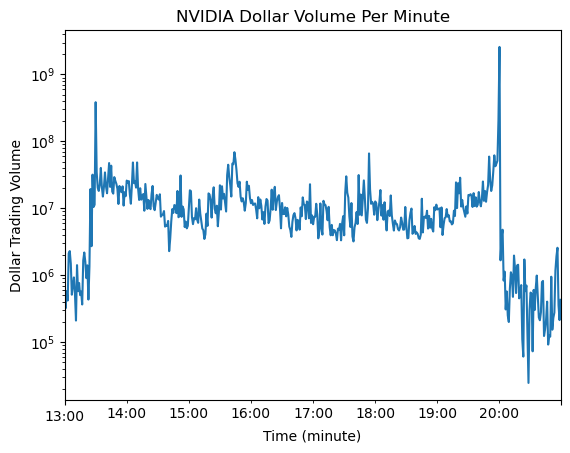

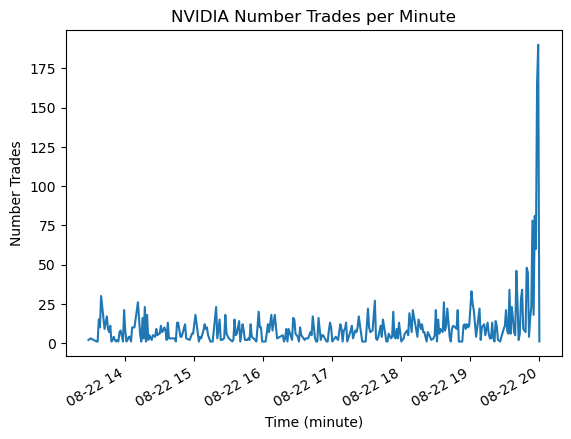

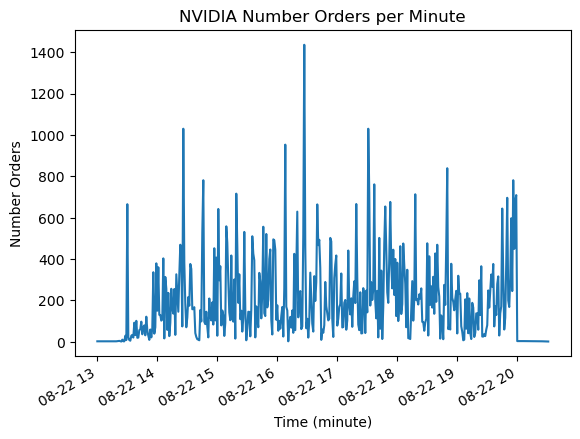



NVIDIA Open:  129.89
NVIDIA Close:  124.33
NVIDIA High:  124.33
NVIDIA Low:  124.33 



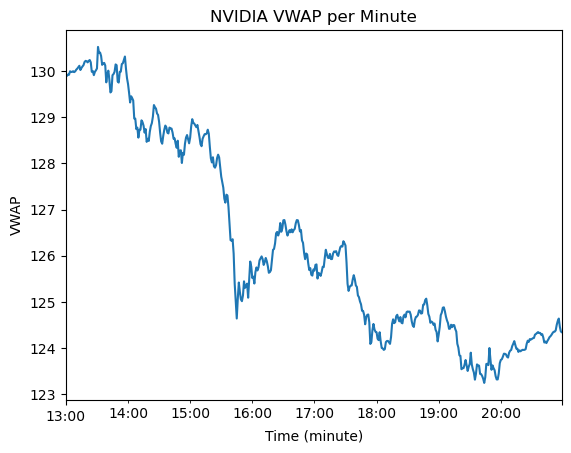

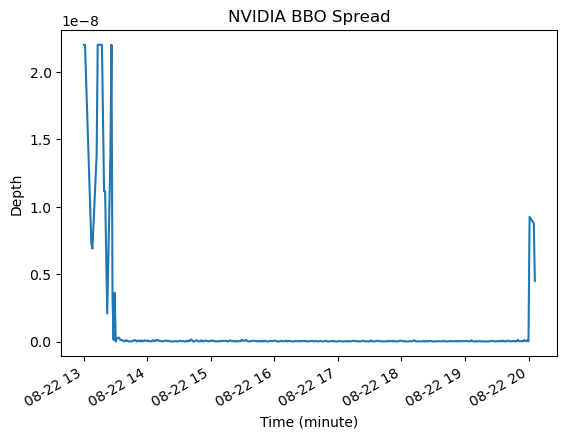

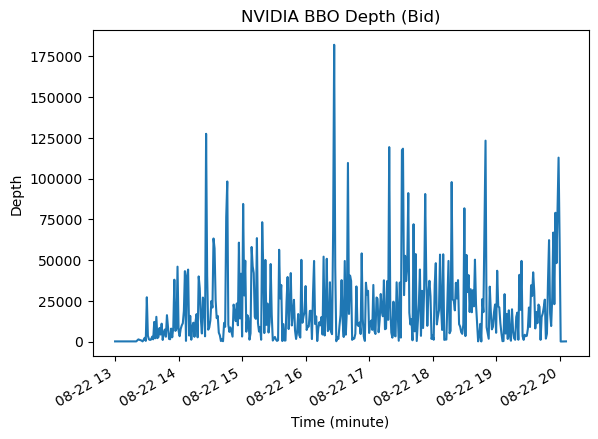

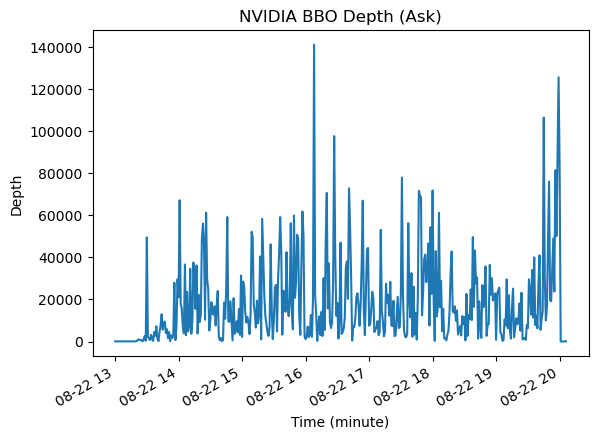

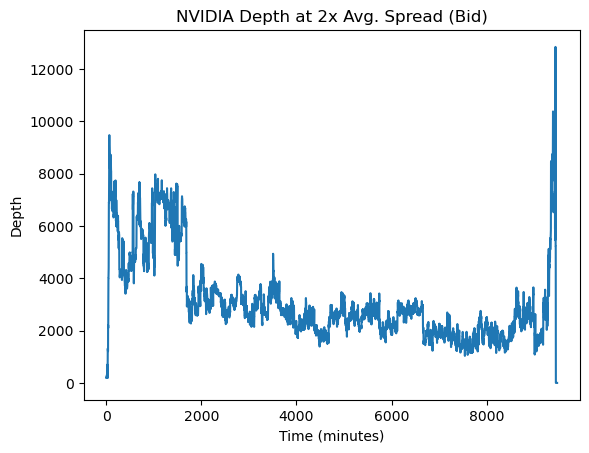

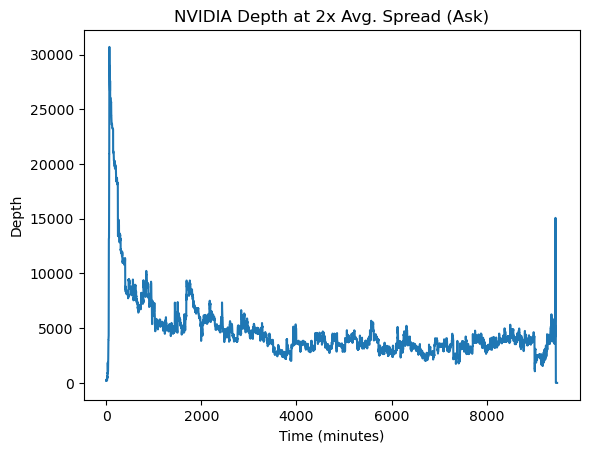

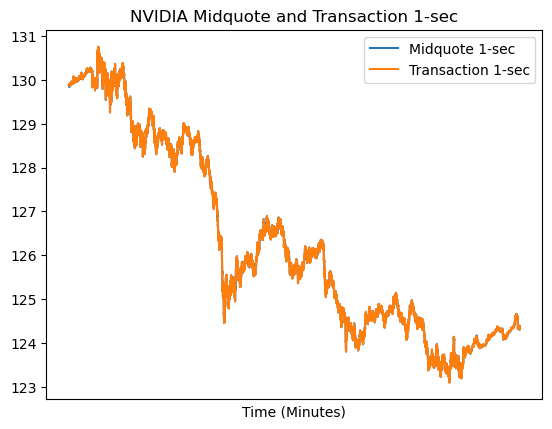

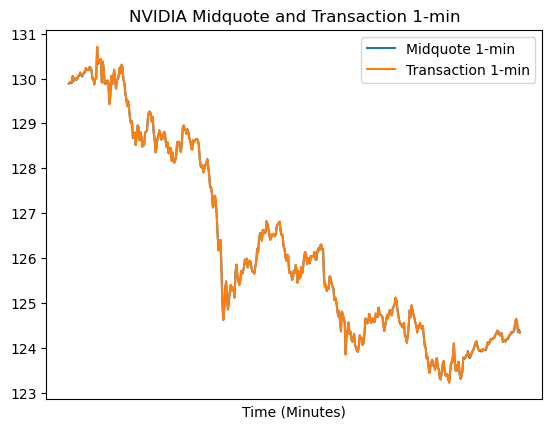

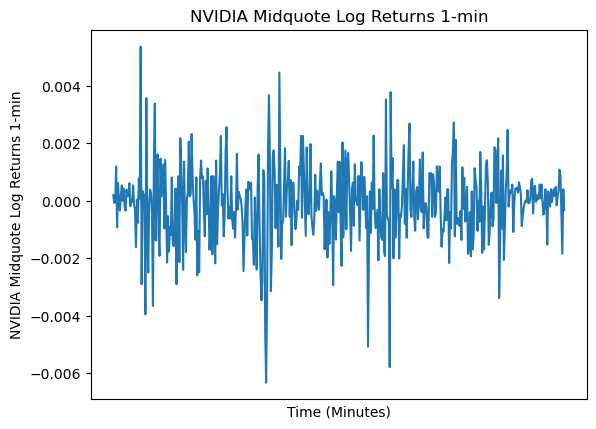

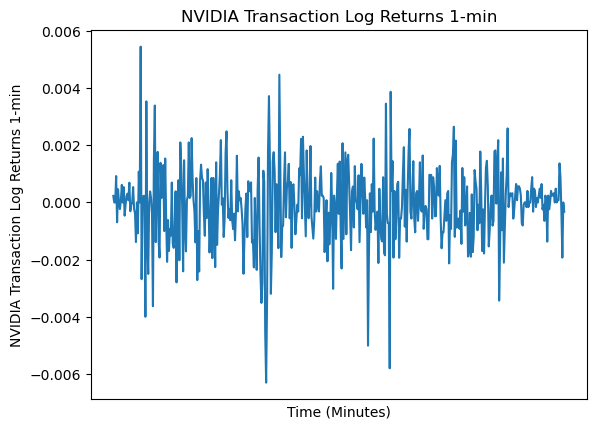

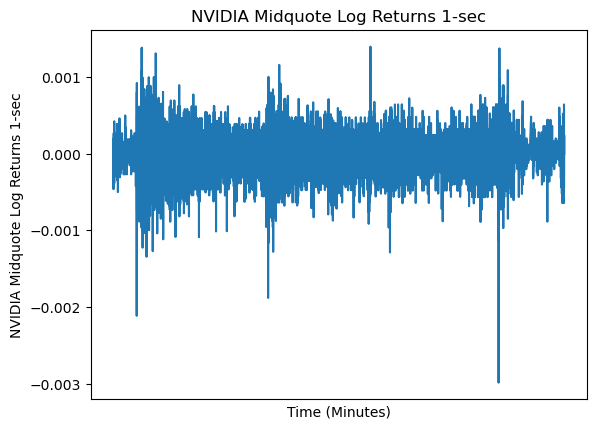

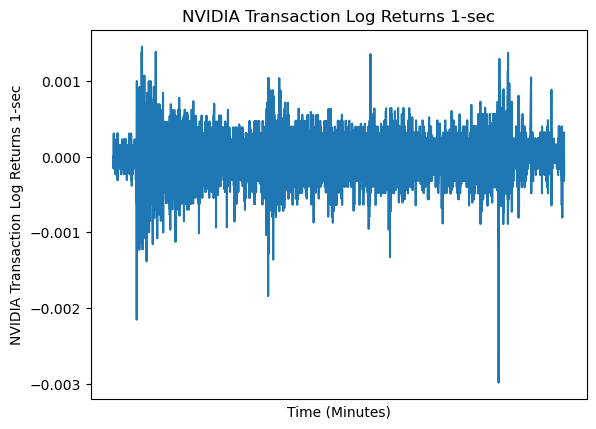

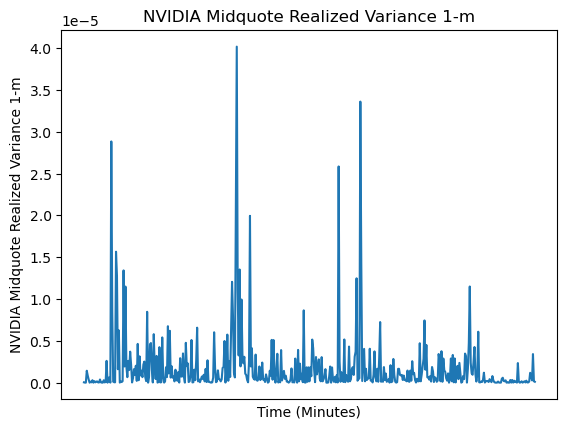

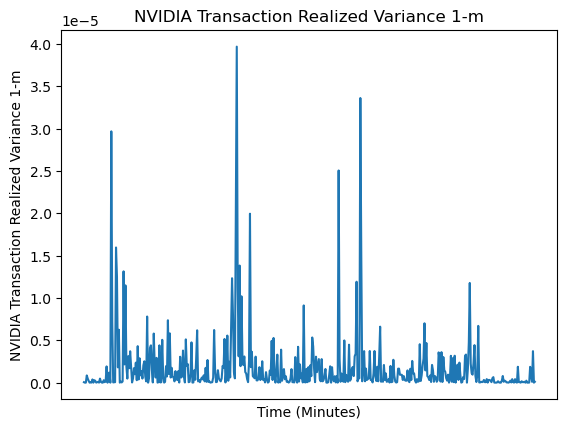

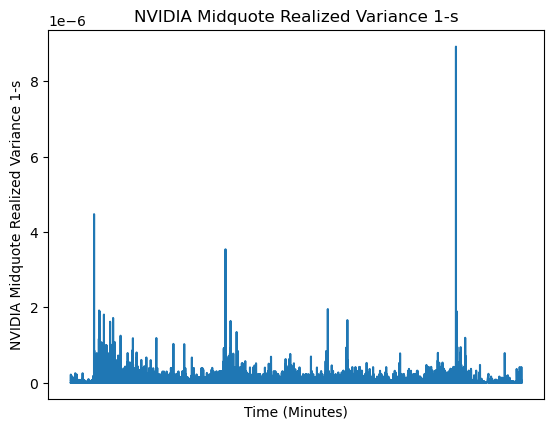

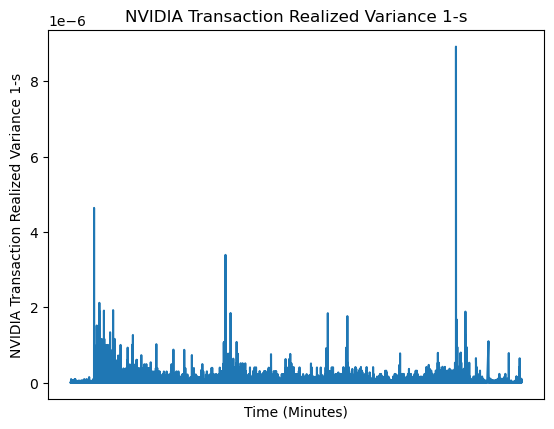

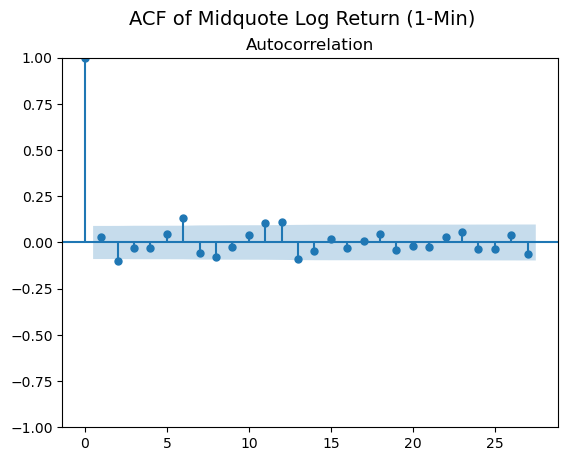

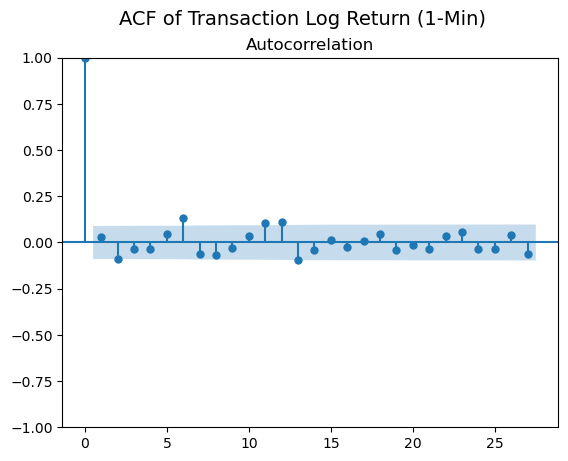

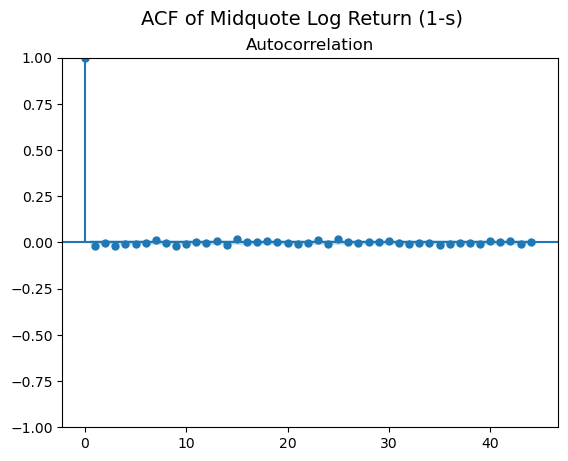

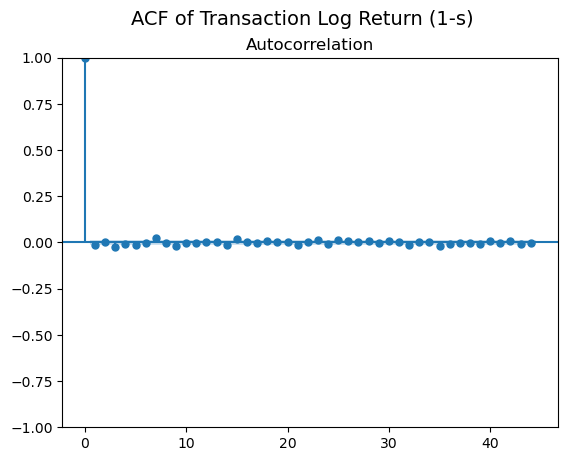

In [79]:
min_stats, sec_stats= calc_summary_statistics(nvda_df_mbo,nvda_df,"NVIDIA")

In [39]:
min_stats

,dollar_vol,number_trades_per_min,number_orders_per_min,vwap,best_bbo_spread,best_bbo_depth_bid,best_bbo_depth_ask,depth_twice_avg_spread_ask,depth_twice_avg_spread_bid,midquote_1min,transaction_1min,midquote_log_return_1min,transaction_log_return_1min,midquote_realized_variance
count,4.800000e+02,297.000000,429.000000,480.000000,4.180000e+02,418.000000,418.000000,9481.000000,9481.000000,480.000000,480.000000,479.000000,479.000000,1.000000
mean,1.765136e+07,10.218855,200.088578,126.273309,8.558852e-10,20455.208134,18740.318182,4731.996203,3115.162852,126.270104,126.271198,-0.000091,-0.000091,0.000857
std,1.191423e+08,17.198638,199.999677,2.191982,3.962432e-09,24602.022528,20555.638578,3089.387195,1615.230876,2.196114,2.196243,0.001336,0.001332,NaN
min,2.471430e+04,1.000000,1.000000,123.242287,0.000000e+00,26.000000,1.000000,0.000000,0.000000,123.225000,123.230000,-0.006338,-0.006298,0.000857
25%,4.741003e+06,3.000000,56.000000,124.382147,1.000000e-11,3509.750000,3901.500000,3288.000000,2068.000000,124.365000,124.370000,-0.000809,-0.000802,0.000857
50%,8.665574e+06,7.000000,144.000000,125.695048,3.000000e-11,11489.500000,12066.000000,3934.000000,2667.000000,125.695000,125.695000,0.000000,0.000000,0.000857
75%,1.464753e+07,12.000000,292.000000,128.533343,5.000000e-11,28443.500000,25480.500000,5076.000000,3404.000000,128.518750,128.522500,0.000635,0.000641,0.000857
max,2.577830e+09,190.000000,1436.000000,130.524562,4.535000e-08,182028.000000,140925.000000,30697.000000,12836.000000,130.705000,130.710000,0.005370,0.005447,0.000857


In [21]:
sec_stats

,midquote_1sec,transaction_1sec
count,23792.000000,23792.000000
mean,126.369438,126.369682
std,2.129374,2.129677
min,123.110000,123.105000
25%,124.575000,124.570000
50%,125.855000,125.860000
75%,128.545000,128.550000
max,130.745000,130.750000


KeyError: 'ask_price'

# g. 5-Second Price Impact

In [ ]:
# need to add more of the stats later

In [ ]:
calc_summary_statistics(nvda_df, nvda_df_mbo, 'NVDA')

In [ ]:
nvda_df.iloc[-1]['price']

# CAKE Summary Statistics

In [ ]:
min_stats,sec_stats=calc_summary_statistics(cake_df_mbo, cake_df, 'CAKE')

In [ ]:
min_stats

In [ ]:
sec_stats

In [ ]:
print(len(nvda_df_mbo))

In [ ]:
cake_df.columns

In [ ]:
results={}
vwap_per_min = nvda_df.groupby(nvda_df['ts_event'].dt.floor('T')).apply(
        lambda x: (x['price'] * x['size']).sum() / x['size'].sum())
results['vwap'] = vwap_per_min.describe()
vwap_per_min.plot(title= ' VWAP per Minute')
plt.xlabel('Time (minute)')
plt.ylabel('VWAP')
plt.show()

In [ ]:
results